# Interpolation of elemental data for comparison between multiple sites

## Importing needed libraries 

In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from skbio.stats.composition import clr
password = open('../password.txt', 'r').read()

## Get data from database

#### Connecting to the database

In [2]:
engine = sqlalchemy.create_engine("postgresql://postgres:%s@localhost/MAYHEM" % password)
con = engine.connect()

#### Insert age depth model output and organic data into dataframe

In [3]:
df_model_output = pd.read_sql('modeloutput', con)
df_model_output = df_model_output.sort_values(by = 'measurementid', ignore_index = True)
df_model_output = df_model_output[df_model_output['model_name'] == 'Undatable']
df_element_output = pd.read_sql('element', con)

#### Close the connection to the database

In [4]:
con.close()

## Prepare data for interpolation

#### Merge elmental data with age depth model median output

In [5]:
df_element = pd.merge(df_element_output[['measurementid','element_name', 'element_value']],
                      df_model_output[['measurementid', 'modeloutput_median']],
                      how = 'outer',
                      on = ['measurementid'])
df_element['coreid'],df_element['compositedepth'] = df_element['measurementid'].str.split(' ', 1).str
df_element['compositedepth'] = df_element['compositedepth'].astype(dtype = float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


#### Sort dataframe and remove unnecessary columns and set index to CoreID

In [6]:
df_element_multiple = df_element.sort_values(by = ['coreid', 'element_name', 'compositedepth'], ignore_index = True)\
.drop(columns = ['measurementid'])
df_element_multiple = df_element_multiple.set_index('coreid')

#### Get a list of unique CoreIDs

In [7]:
CoreID_List = list(df_element_multiple.index.unique())

**Individually interpolate (piecewise polynomial) the model output median for the composite depth measurement of elemental data for each CoreID, so that every elemental measurement has a median age - for this a dummy variable helps to allow interpolation\
Then combine each CoreID in one dataframe with the age median as index**

In [8]:
df_element_total = pd.DataFrame()
for i in CoreID_List:
    df2 = df_element_multiple.loc[i].reset_index(drop = False)
    if df2.iloc[:,1].isnull().all() == True:
        del(df2)
        continue
    else:
        df2['element_name'] = df2.element_name.fillna('Dummy')
        df2 = df2.set_index('element_name', drop = False)
        List_u_element = list(df2.index.unique())
        if 'Dummy' in List_u_element:
            List_u_element.pop(-1)
            df_element_combined = pd.DataFrame(columns = ['coreid', 'element_name', 'element_value','modeloutput_median'])
            for e in List_u_element:
                df_element_slice = df2.loc[[e, 'Dummy']]
                df_element_slice = df_element_slice.sort_values(by = 'compositedepth')
                df_element_slice = df_element_slice.set_index('compositedepth')
                df_element_slice['modeloutput_median'] = df_element_slice.modeloutput_median.interpolate('from_derivatives') ## scipy.interpolate.BPoly.from_derivatives
                df_element_combined = df_element_combined.append(df_element_slice)
        else:
            df_element_combined = pd.DataFrame(columns = ['coreid', 'element_name', 'element_value','modeloutput_median'])
            for e in List_u_element:
                df_element_slice = df2.loc[[e]]
                df_element_slice = df_element_slice.sort_values(by = 'compositedepth')
                df_element_slice = df_element_slice.set_index('compositedepth')
                df_element_slice['modeloutput_median'] = df_element_slice.modeloutput_median.interpolate('from_derivatives') ## scipy.interpolate.BPoly.from_derivatives
                df_element_combined = df_element_combined.append(df_element_slice)
        ### 2nd loop to remove NA's from output_median
        for j in range(0, len(df_element_combined.modeloutput_median)):
            try:
                if np.isnan(df_element_combined.iloc[j,3]):
                    df_element_combined = df_element_combined.drop(df_element_combined.index[[j]])
                else:
                    pass
            except (IndexError):
                if np.isnan(df_element_combined.iloc[-1,3]):
                    df_element_combined = df_element_combined.drop(ddf_element_combinedf2.index[-1])
                else:
                    pass
        df_element_combined = df_element_combined.astype({'modeloutput_median': 'int32'})
        df_element_combined = df_element_combined.reset_index()
        df_element_combined = df_element_combined.pivot_table(index = ['modeloutput_median', 'coreid'], columns = 'element_name', values = 'element_value')
        df_element_total = df_element_total.append(df_element_combined)

#### Select XRF data from the elemental data (as this data has a very high resolution)

In [9]:
xrf_columns = [x for x in df_element_total.columns if "_Area" in x]
df_element_xrf = df_element_total[xrf_columns]
df_element_xrf = df_element_xrf.dropna(how = 'all')

#### Remove negative values (as clr only works with positive values)

In [10]:
df_element_xrf =  df_element_xrf.mask(df_element_xrf < 0, 1) ## sets values below 0 to 1

#### Apply clr transformation to each CoreID and combine the results in one dataframe

In [11]:
xrf_coreid_list = list(df_element_xrf.reset_index().set_index('coreid').index.unique())
df_element_xrf_clr = pd.DataFrame()
for element in xrf_coreid_list:
    df_element_xrf_slice = df_element_xrf.xs(element, level = 'coreid', drop_level = False)
    df_element_xrf_slice = df_element_xrf_slice.dropna(axis = 1, how = 'all')
    for parameter in df_element_xrf_slice.columns:
        if df_element_xrf_slice[parameter].sum() == 0:
            df_element_xrf_slice = df_element_xrf_slice.drop(columns = [parameter])
        else:
            pass
    clr_values = clr(df_element_xrf_slice)
    df_clr_transformed = pd.DataFrame(clr_values, columns = df_element_xrf_slice.columns, index = df_element_xrf_slice.index)
    df_element_xrf_clr = df_element_xrf_clr.append(df_clr_transformed)

C:\ProgramData\Anaconda3\lib\site-packages\scikit_bio-0.5.6-py3.7-win-amd64.egg\skbio\stats\composition.py:464: RuntimeWarning: divide by zero encountered in log
  lmat = np.log(mat)
C:\ProgramData\Anaconda3\lib\site-packages\scikit_bio-0.5.6-py3.7-win-amd64.egg\skbio\stats\composition.py:466: RuntimeWarning: invalid value encountered in subtract
  return (lmat - gm).squeeze()
C:\ProgramData\Anaconda3\lib\site-packages\scikit_bio-0.5.6-py3.7-win-amd64.egg\skbio\stats\composition.py:150: RuntimeWarning: invalid value encountered in less
  if np.any(mat < 0):


## Plotting CLR transformated elemental data for each element

In [12]:
def hex_to_rgb(hex_value):
  h = hex_value.lstrip('#')
  return tuple(int(h[i:i + 2], 16) / 255.0 for i in (0, 2, 4))

## Aluminium

In [13]:
df_Al_Area = df_element_xrf_clr['Al_Area'].to_frame()
df_Al_Area = df_Al_Area.dropna()
df_Al_Area = df_Al_Area.reset_index()
df_Al_Area = df_Al_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Al_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [14]:
df_Al_Area = df_Al_Area.reindex(range(int(df_Al_Area.index[0]),int(df_Al_Area.index[-1])+1, 1))
df_Al_Area_interpolate = df_Al_Area.interpolate('from_derivatives')
Al_Area_Comparable = df_Al_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Al_Area'})

#### Plotting data

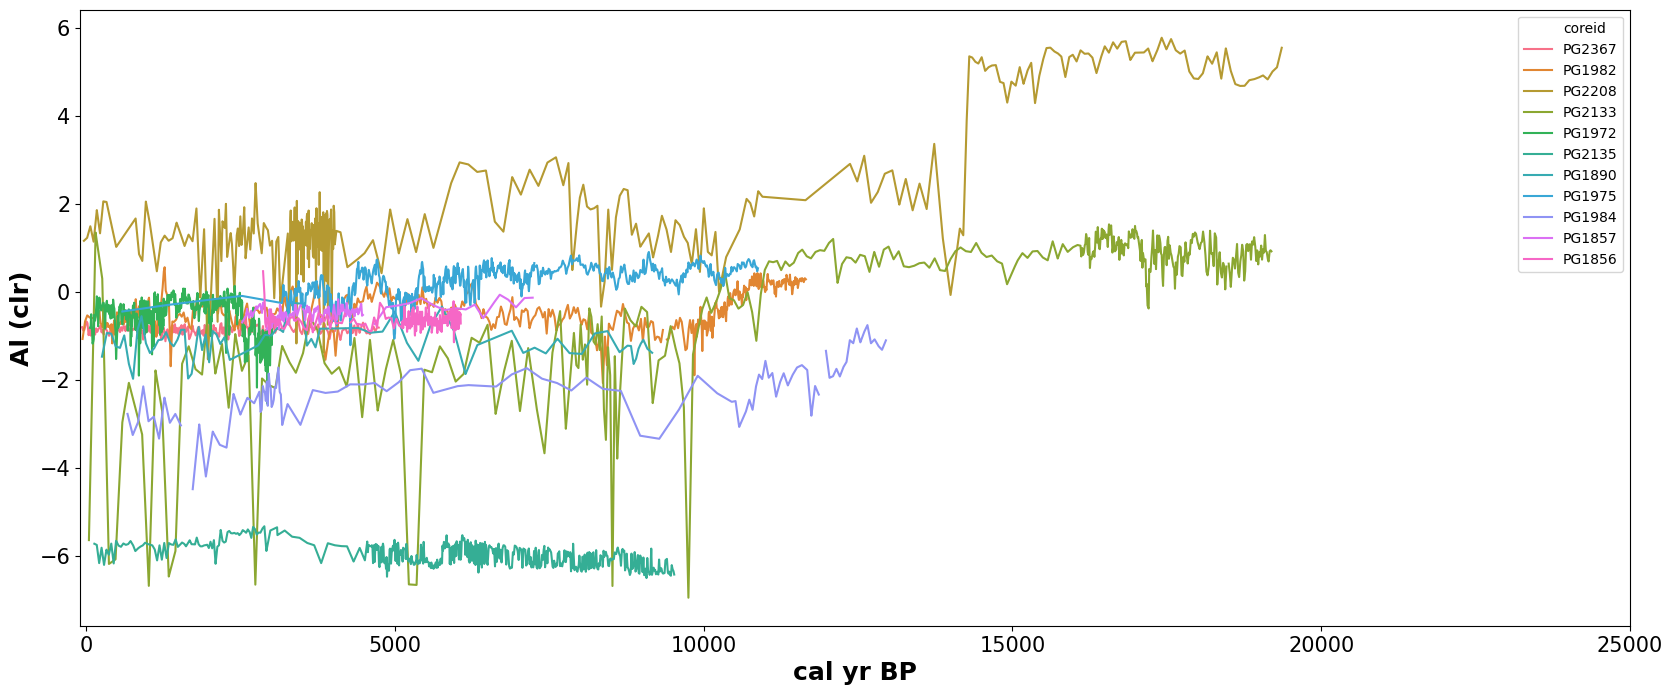

In [15]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Al_Area', hue = 'coreid', data = Al_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylabel('Al (clr)', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/clr_Al_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Silicium

In [13]:
df_Si_Area = df_element_xrf_clr['Si_Area'].to_frame()
df_Si_Area = df_Si_Area.dropna()
df_Si_Area = df_Si_Area.reset_index()
df_Si_Area = df_Si_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Si_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [14]:
df_Si_Area = df_Si_Area.reindex(range(int(df_Si_Area.index[0]),int(df_Si_Area.index[-1])+1, 1))
df_Si_Area_interpolate = df_Si_Area.interpolate('from_derivatives')
Si_Area_Comparable = df_Si_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Si_Area'})
Si_Area_Comparable = Si_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

In [15]:
print ('Colors needed for the palette: %s \nFor the following cores:' % len(Si_Area_Comparable.coreid.unique()))
print (list(Si_Area_Comparable.coreid.unique()))

Colors needed for the palette: 11 
For the following cores:
['PG1856', 'PG1857', 'PG1890', 'PG1972', 'PG1975', 'PG1982', 'PG1984', 'PG2133', 'PG2135', 'PG2208', 'PG2367']


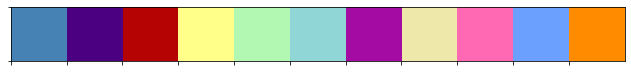

In [16]:
hex_colors = ['#4682b4', #steelblue        ## PG1856
              '#4b0082', #indigo           ## PG1857
              '#b50202', #free speech red  ## PG1890
              '#ffff8a', #canary           ## PG1972
              '#b2f7b2', #palegreen        ## PG1975
              '#90d6d6', #aqua island      ## PG1982
              '#a30ba3', #dark magenta     ## PG1984
              '#eee8aa', #palegoldenrod    ## PG2133
              '#ff69b4', #hotpink          ## PG2135
              '#6ba0ff', #cornflower       ## PG2208
              '#ff8c00'  #darkorange       ## PG2367
             ]

Si_palette_colors = list(map(hex_to_rgb, hex_colors))
sns.palplot(Si_palette_colors)

#### Plotting data

No handles with labels found to put in legend.


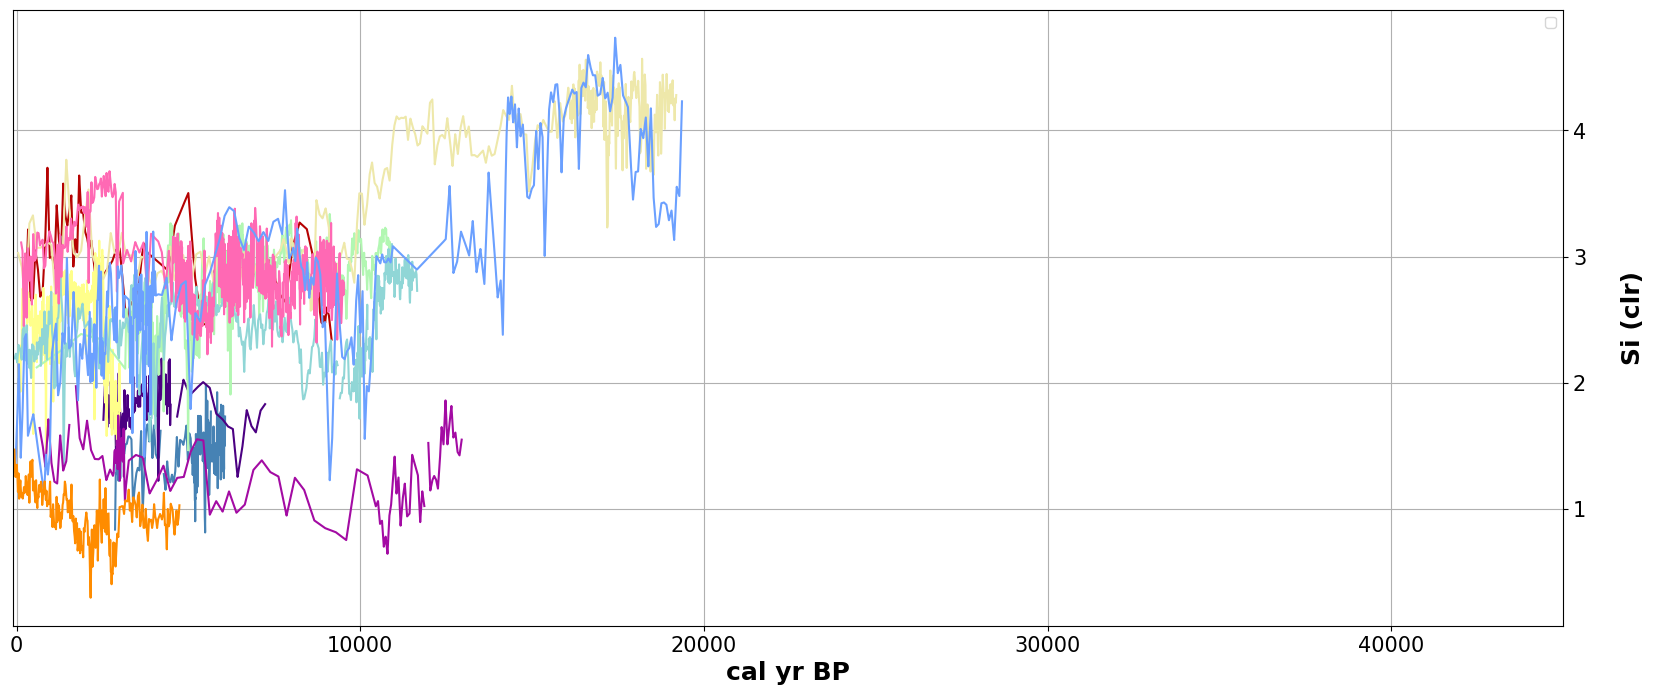

In [17]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rcParams["ytick.labelleft"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelright"] = True
plt.rcParams["ytick.right"] = True
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Si_Area', 
                  hue = 'coreid', data = Si_Area_Comparable, 
                  palette = Si_palette_colors, legend = False)
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Si (clr)', weight = 'bold', labelpad = -1175)
plt.xlabel('cal yr BP', weight = 'bold')
plt.grid(True)
plt.savefig('Figures/clr_Si_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Al/Si

In [21]:
Al_Si = pd.merge(Al_Area_Comparable, Si_Area_Comparable, how = 'inner', on = ['coreid', 'modeloutput_median'])
Al_Si['Ratio'] = Al_Si['Al_Area']/Al_Si['Si_Area']

#### Plotting data

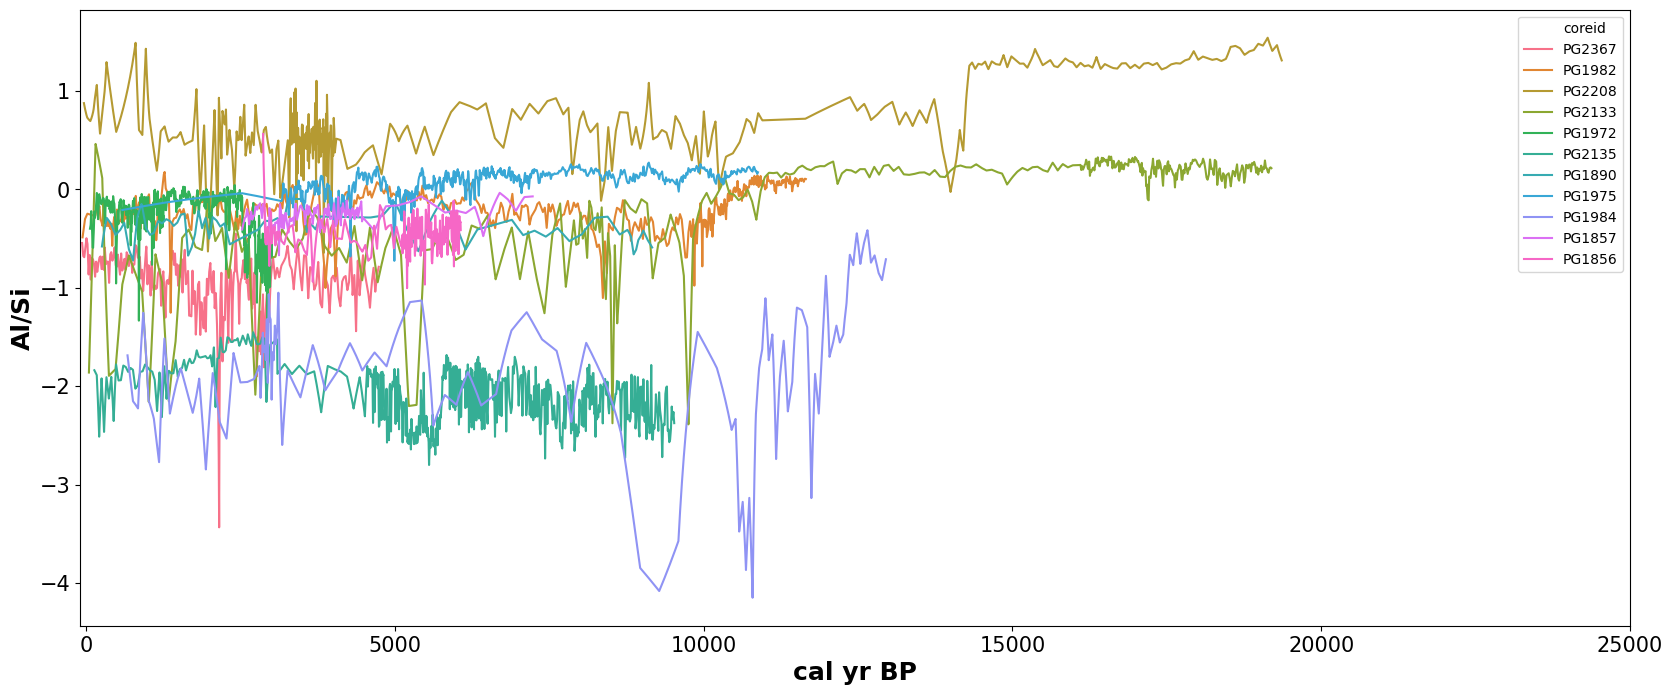

In [22]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ratio', hue = 'coreid', data = Al_Si, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylabel('Al/Si', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/clr_Al_Si.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Bromine

In [18]:
df_Br_Area = df_element_xrf_clr['Br_Area'].to_frame()
df_Br_Area = df_Br_Area.dropna()
df_Br_Area = df_Br_Area.reset_index()
df_Br_Area = df_Br_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Br_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [19]:
df_Br_Area = df_Br_Area.reindex(range(int(df_Br_Area.index[0]),int(df_Br_Area.index[-1])+1, 1))
df_Br_Area_interpolate = df_Br_Area.interpolate('from_derivatives')
Br_Area_Comparable = df_Br_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Br_Area'})
Br_Area_Comparable = Br_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

In [20]:
print ('Colors needed for the palette: %s \nFor the following cores: ' % len(Br_Area_Comparable.coreid.unique()))
print (list(Br_Area_Comparable.coreid.unique()))

Colors needed for the palette: 8 
For the following cores: 
['PG1972', 'PG1975', 'PG1982', 'PG2023', 'PG2133', 'PG2135', 'PG2208', 'PG2367']


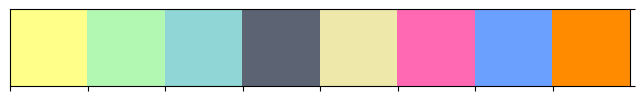

In [21]:
hex_colors = ['#ffff8a', #canary           ## PG1972
              '#b2f7b2', #palegreen        ## PG1975
              '#90d6d6', #aqua island      ## PG1982
              '#5c6473', #shuttle grey     ## PG2023
              '#eee8aa', #palegoldenrod    ## PG2133
              '#ff69b4', #hotpink          ## PG2135
              '#6ba0ff', #cornflower       ## PG2208
              '#ff8c00'  #darkorange       ## PG2367
             ]


Br_palette_colors = list(map(hex_to_rgb, hex_colors))
sns.palplot(Br_palette_colors)

#### Plotting data

No handles with labels found to put in legend.


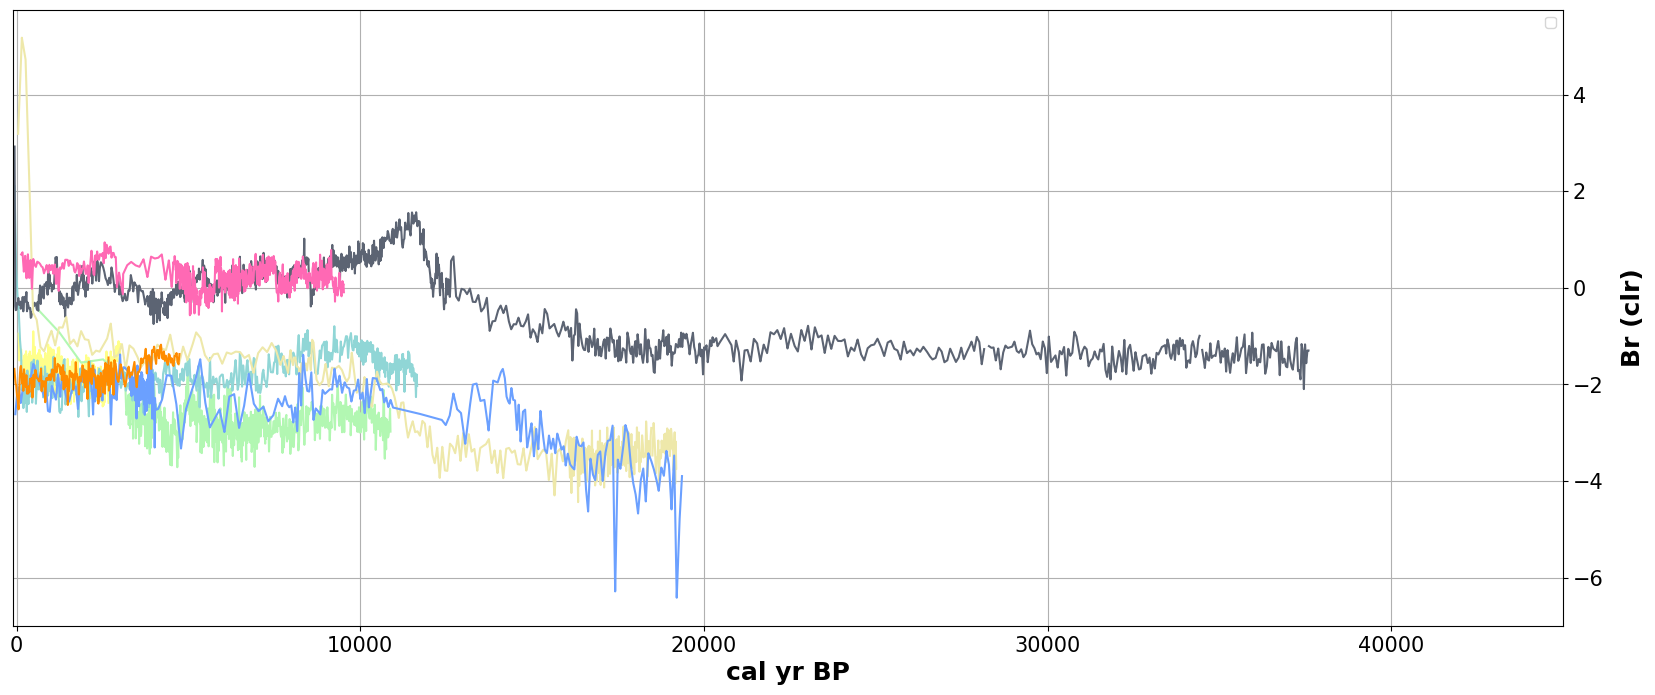

In [22]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rcParams["ytick.labelleft"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelright"] = True
plt.rcParams["ytick.right"] = True
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Br_Area', 
                  hue = 'coreid', data = Br_Area_Comparable, 
                  palette = Br_palette_colors, legend = False)
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Br (clr)', weight = 'bold', labelpad = -1175)
plt.xlabel('cal yr BP', weight = 'bold')
plt.grid(True)
plt.savefig('Figures/clr_Br_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Titanium

In [23]:
df_Ti_Area = df_element_xrf_clr['Ti_Area'].to_frame()
df_Ti_Area = df_Ti_Area.dropna()
df_Ti_Area = df_Ti_Area.reset_index()
df_Ti_Area = df_Ti_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Ti_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [24]:
df_Ti_Area = df_Ti_Area.reindex(range(int(df_Ti_Area.index[0]),int(df_Ti_Area.index[-1])+1, 1))
df_Ti_Area_interpolate = df_Ti_Area.interpolate('from_derivatives')
Ti_Area_Comparable = df_Ti_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Ti_Area'})
Ti_Area_Comparable = Ti_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

In [25]:
print ('Colors needed for the palette: %s \nFor the following cores: ' % len(Ti_Area_Comparable.coreid.unique()))
print (list(Ti_Area_Comparable.coreid.unique()))

Colors needed for the palette: 13 
For the following cores: 
['PG1755', 'PG1756', 'PG1856', 'PG1857', 'PG1890', 'PG1972', 'PG1975', 'PG1982', 'PG1984', 'PG2133', 'PG2135', 'PG2208', 'PG2367']


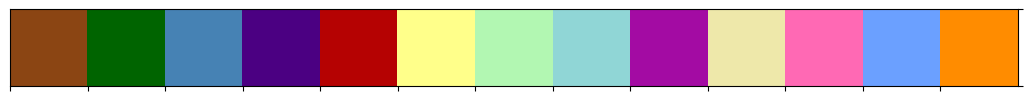

In [26]:
hex_colors = ['#8b4513', #saddlebrown      ## PG1755
              '#006400', #darkgreen        ## PG1756
              '#4682b4', #steelblue        ## PG1856
              '#4b0082', #indigo           ## PG1857
              '#b50202', #free speech red  ## PG1890
              '#ffff8a', #canary           ## PG1972
              '#b2f7b2', #palegreen        ## PG1975
              '#90d6d6', #aqua island      ## PG1982
              '#a30ba3', #dark magenta     ## PG1984
              '#eee8aa', #palegoldenrod    ## PG2133
              '#ff69b4', #hotpink          ## PG2135
              '#6ba0ff', #cornflower       ## PG2208
              '#ff8c00'  #darkorange       ## PG2367
             ]

Ti_palette_colors = list(map(hex_to_rgb, hex_colors))
sns.palplot(Ti_palette_colors)

#### Plotting data

No handles with labels found to put in legend.


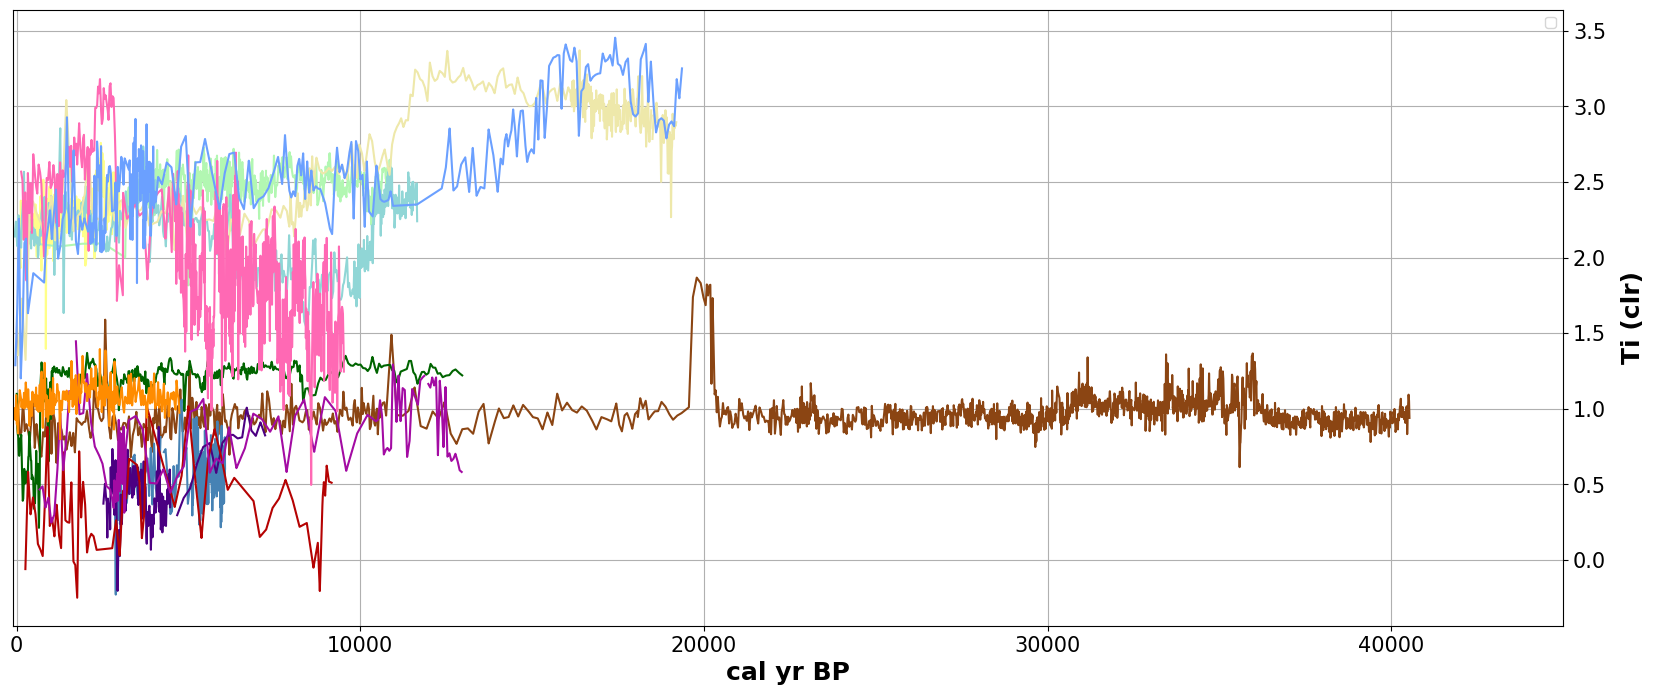

In [27]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rcParams["ytick.labelleft"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelright"] = True
plt.rcParams["ytick.right"] = True
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ti_Area', 
                  hue = 'coreid', data = Ti_Area_Comparable, 
                  palette = Ti_palette_colors, legend = False)
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Ti (clr)', weight = 'bold', labelpad = -1175)
plt.xlabel('cal yr BP', weight = 'bold')
plt.grid(True)
plt.savefig('Figures/clr_Ti_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Zircon

In [33]:
df_Zr_Area = df_element_xrf_clr['Zr_Area'].to_frame()
df_Zr_Area = df_Zr_Area.dropna()
df_Zr_Area = df_Zr_Area.reset_index()
df_Zr_Area = df_Zr_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Zr_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [34]:
df_Zr_Area = df_Zr_Area.reindex(range(int(df_Zr_Area.index[0]),int(df_Zr_Area.index[-1])+1, 1))
df_Zr_Area_interpolate = df_Zr_Area.interpolate('from_derivatives')
Zr_Area_Comparable = df_Zr_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Zr_Area'})

#### Plotting data

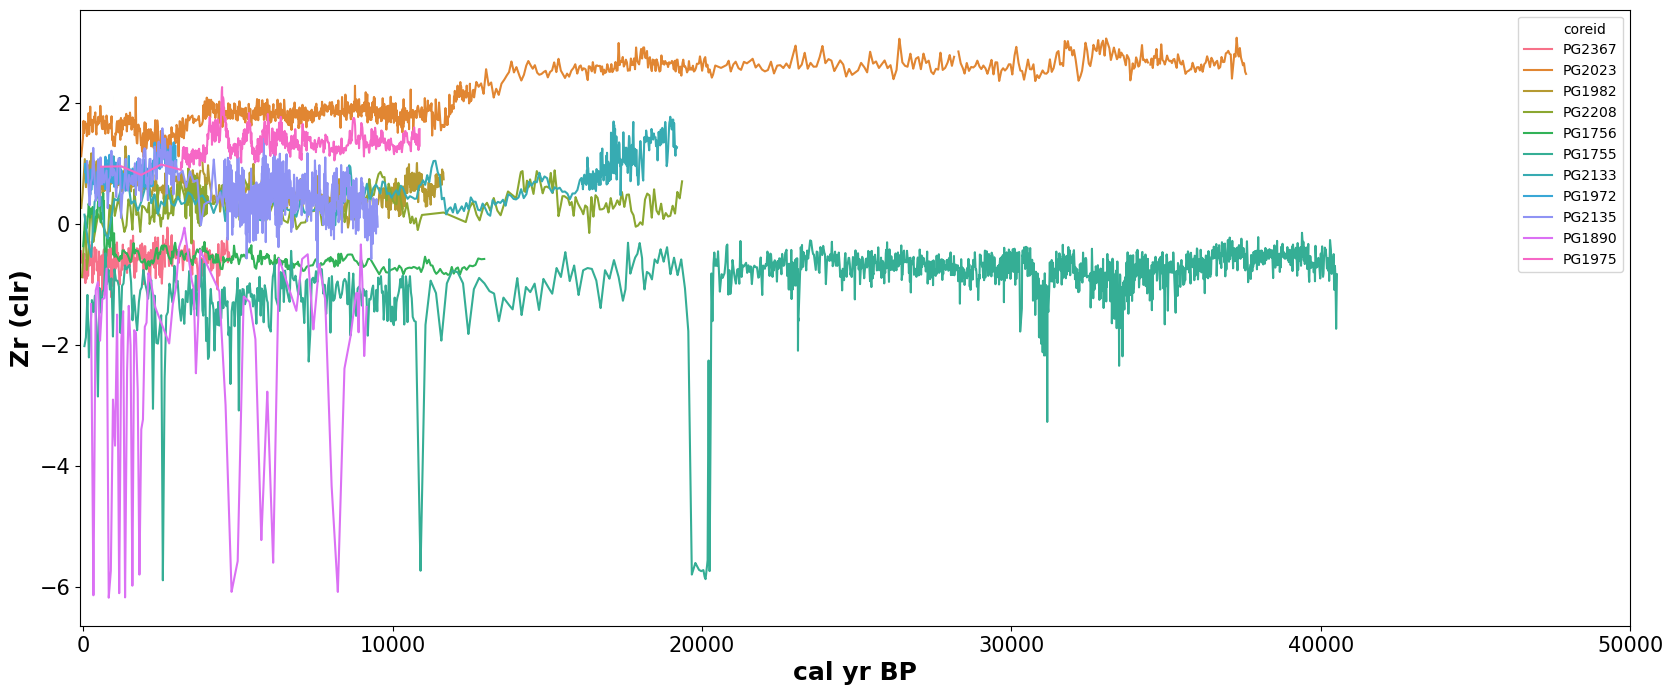

In [35]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Zr_Area', hue = 'coreid', data = Zr_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 50000)
plt.ylabel('Zr (clr)', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/clr_Zr_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Calcium

In [28]:
df_Ca_Area = df_element_xrf_clr['Ca_Area'].to_frame()
df_Ca_Area = df_Ca_Area.dropna()
df_Ca_Area = df_Ca_Area.reset_index()
df_Ca_Area = df_Ca_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Ca_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [29]:
df_Ca_Area = df_Ca_Area.reindex(range(int(df_Ca_Area.index[0]),int(df_Ca_Area.index[-1])+1, 1))
df_Ca_Area_interpolate = df_Ca_Area.interpolate('from_derivatives')
Ca_Area_Comparable = df_Ca_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Ca_Area'})
Ca_Area_Comparable = Ca_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

In [30]:
print ('Colors needed for the palette: %s \nFor the following cores:' % len(Ca_Area_Comparable.coreid.unique()))
print (list(Ca_Area_Comparable.coreid.unique()))

Colors needed for the palette: 13 
For the following cores:
['PG1755', 'PG1756', 'PG1856', 'PG1857', 'PG1890', 'PG1972', 'PG1975', 'PG1982', 'PG1984', 'PG2133', 'PG2135', 'PG2208', 'PG2367']


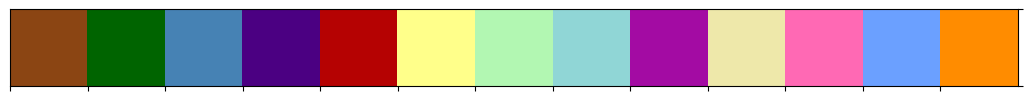

In [31]:
hex_colors = ['#8b4513', #saddlebrown      ## PG1755
              '#006400', #darkgreen        ## PG1756
              '#4682b4', #steelblue        ## PG1856
              '#4b0082', #indigo           ## PG1857
              '#b50202', #free speech red  ## PG1890
              '#ffff8a', #canary           ## PG1972
              '#b2f7b2', #palegreen        ## PG1975
              '#90d6d6', #aqua island      ## PG1982
              '#a30ba3', #dark magenta     ## PG1984
              '#eee8aa', #palegoldenrod    ## PG2133
              '#ff69b4', #hotpink          ## PG2135
              '#6ba0ff', #cornflower       ## PG2208
              '#ff8c00'  #darkorange       ## PG2367
             ]

Ca_palette_colors = list(map(hex_to_rgb, hex_colors))
sns.palplot(Ca_palette_colors)

#### Plotting data

No handles with labels found to put in legend.


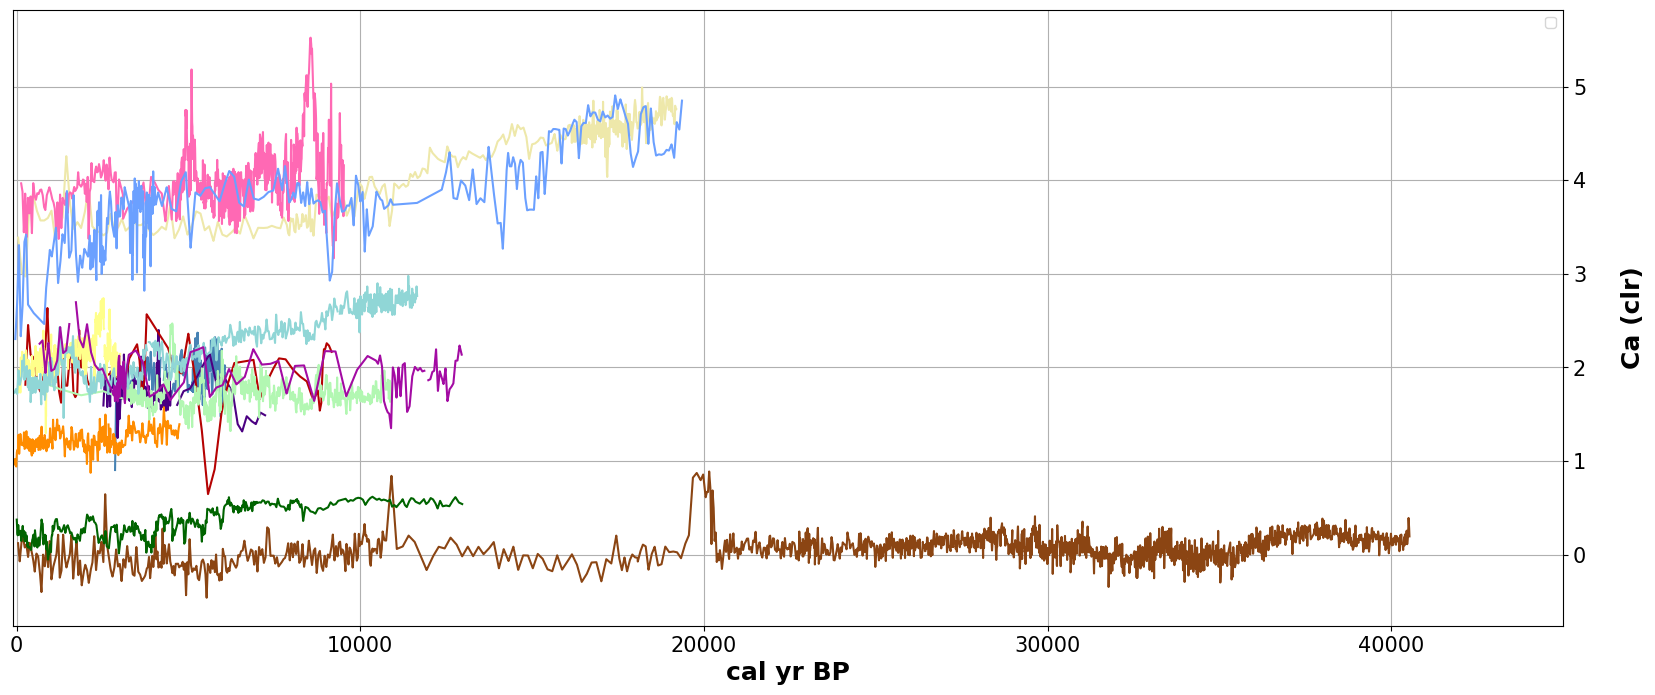

In [32]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rcParams["ytick.labelleft"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelright"] = True
plt.rcParams["ytick.right"] = True
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ca_Area', 
                  hue = 'coreid', data = Ca_Area_Comparable, 
                  palette = Ca_palette_colors, legend = False)
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Ca (clr)', weight = 'bold', labelpad = -1175)
plt.xlabel('cal yr BP', weight = 'bold')
plt.grid(True)
plt.savefig('Figures/clr_Ca_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Manganese

In [41]:
df_Mn_Area = df_element_xrf_clr['Mn_Area'].to_frame()
df_Mn_Area = df_Mn_Area.dropna()
df_Mn_Area = df_Mn_Area.reset_index()
df_Mn_Area = df_Mn_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Mn_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [42]:
df_Mn_Area = df_Mn_Area.reindex(range(int(df_Mn_Area.index[0]),int(df_Mn_Area.index[-1])+1, 1))
df_Mn_Area_interpolate = df_Mn_Area.interpolate('from_derivatives')
Mn_Area_Comparable = df_Mn_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Mn_Area'})

#### Plotting data

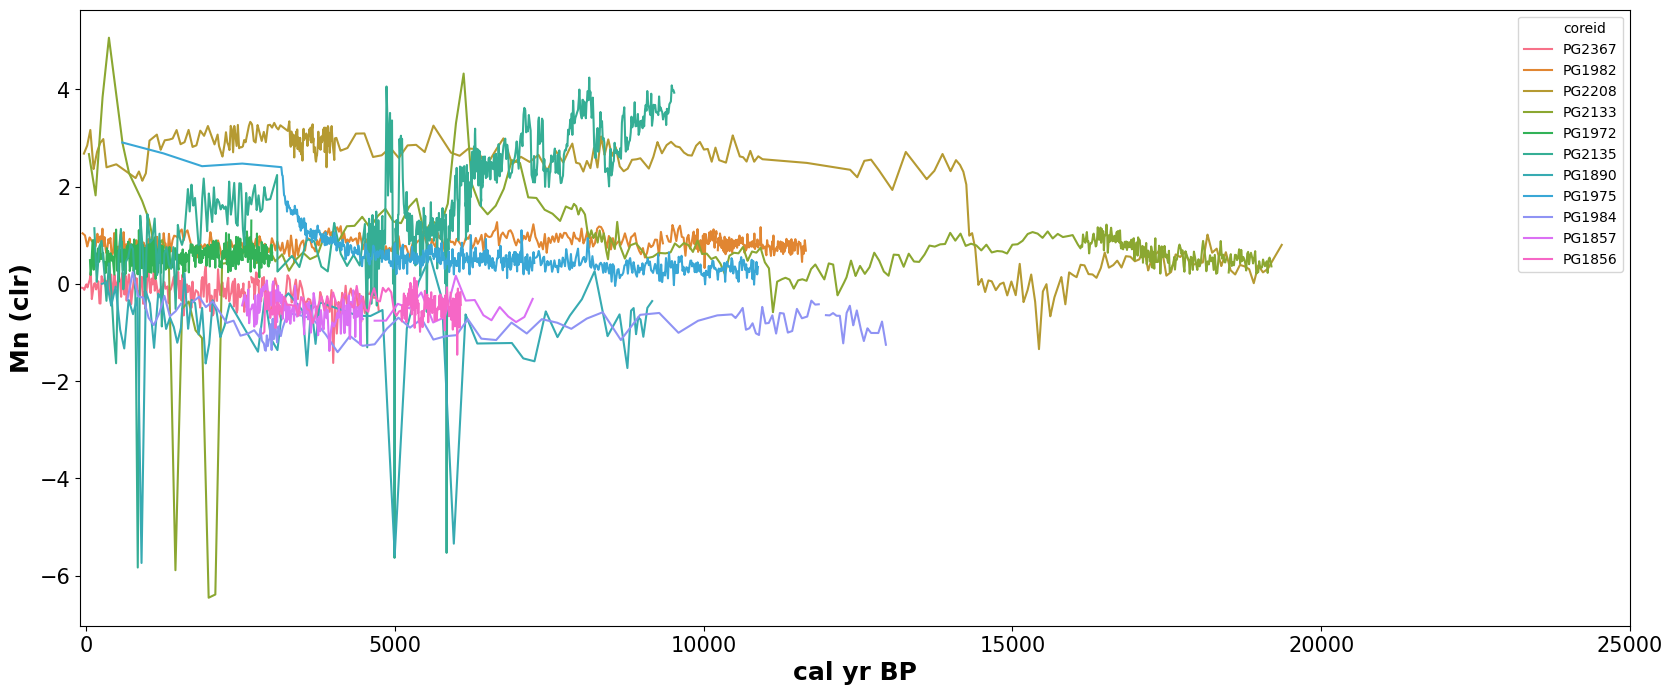

In [43]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Mn_Area', hue = 'coreid', data = Mn_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylabel('Mn (clr)', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/clr_Mn_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Iron

In [44]:
df_Fe_Area = df_element_xrf_clr['Fe_Area'].to_frame()
df_Fe_Area = df_Fe_Area.dropna()
df_Fe_Area = df_Fe_Area.reset_index()
df_Fe_Area = df_Fe_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Fe_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [45]:
df_Fe_Area = df_Fe_Area.reindex(range(int(df_Fe_Area.index[0]),int(df_Fe_Area.index[-1])+1, 1))
df_Fe_Area_interpolate = df_Fe_Area.interpolate('from_derivatives')
Fe_Area_Comparable = df_Fe_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Fe_Area'})

#### Plotting data

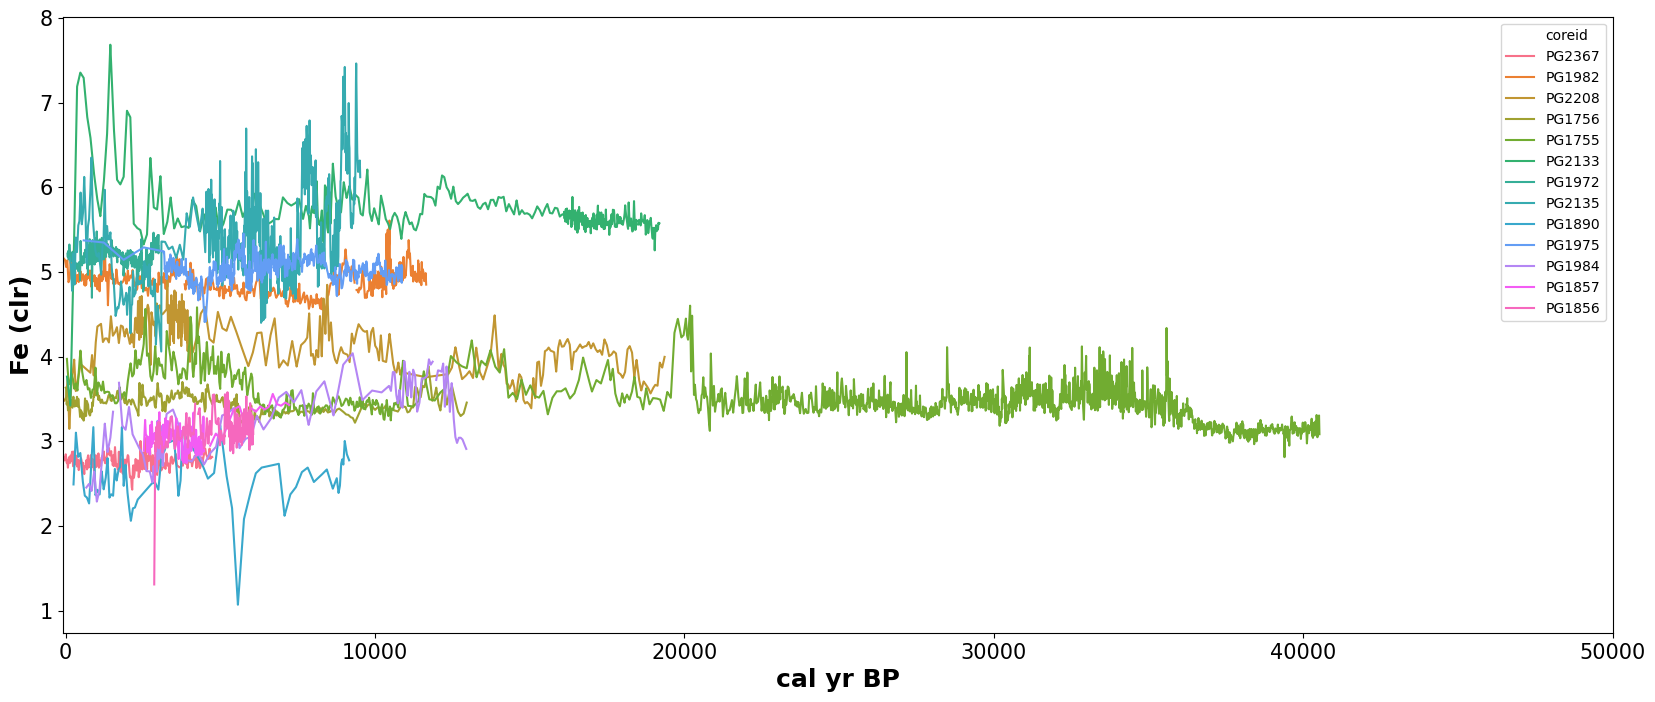

In [46]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Fe_Area', hue = 'coreid', data = Fe_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 50000)
plt.ylabel('Fe (clr)', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/clr_Fe_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Mn/Fe Ratio

In [47]:
Mn_Fe = pd.merge(Mn_Area_Comparable, Fe_Area_Comparable, how = 'inner', on = ['coreid', 'modeloutput_median'])
Mn_Fe['Ratio'] = Mn_Fe['Mn_Area']/Mn_Fe['Fe_Area']

#### Plotting data

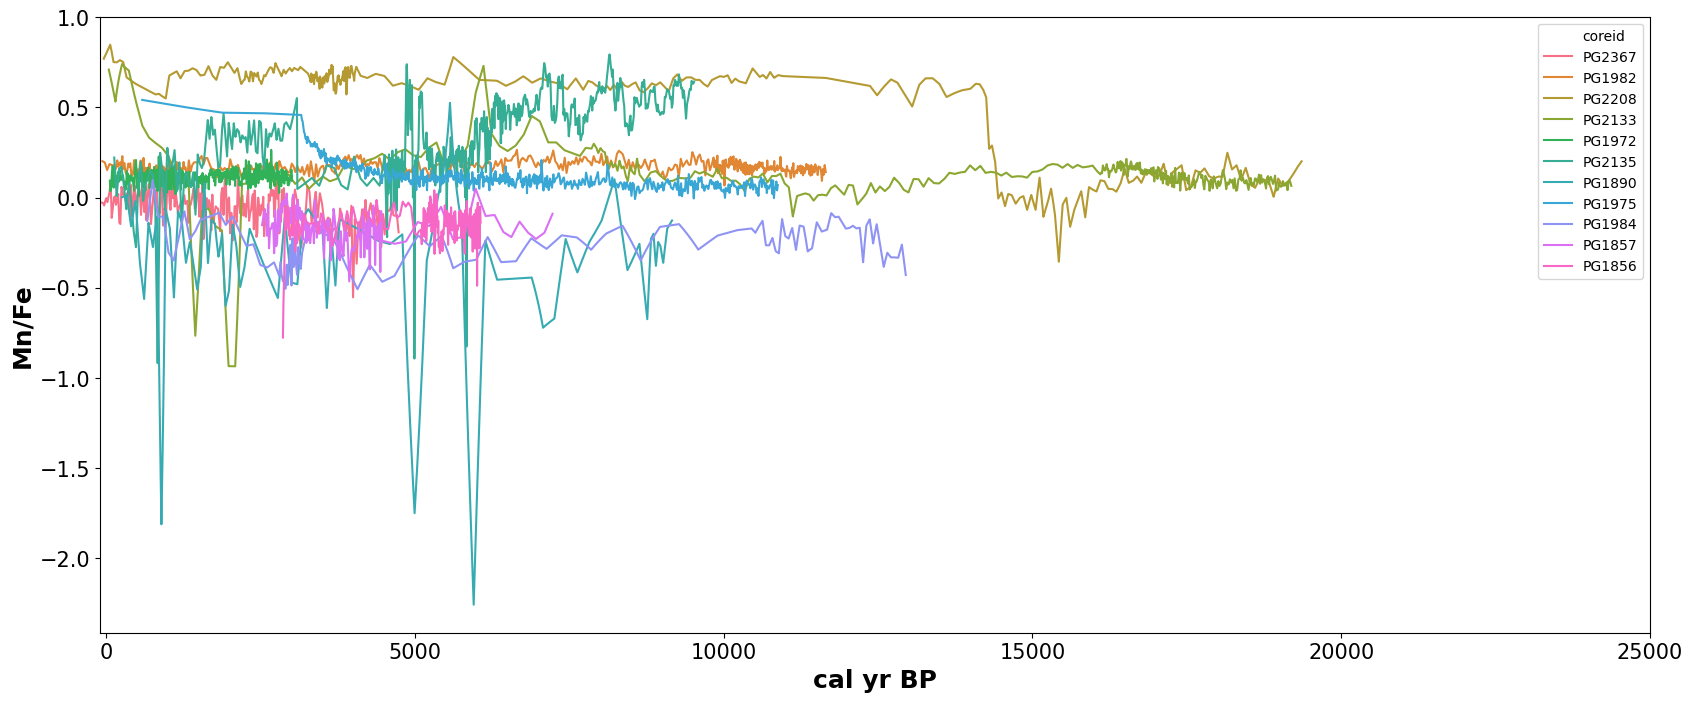

In [48]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ratio', hue = 'coreid', data = Mn_Fe, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylabel('Mn/Fe', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/clr_Mn_Fe.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Plotting cps values of elemental data for each element

## Aluminium

In [49]:
df_Al_Area = df_element_total['Al_Area'].to_frame()
df_Al_Area = df_Al_Area.dropna()
df_Al_Area = df_Al_Area.reset_index()
df_Al_Area = df_Al_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Al_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [50]:
df_Al_Area = df_Al_Area.reindex(range(int(df_Al_Area.index[0]),int(df_Al_Area.index[-1])+1, 1))
df_Al_Area_interpolate = df_Al_Area.interpolate('from_derivatives')
Al_Area_Comparable = df_Al_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Al_Area'})

#### Plotting data

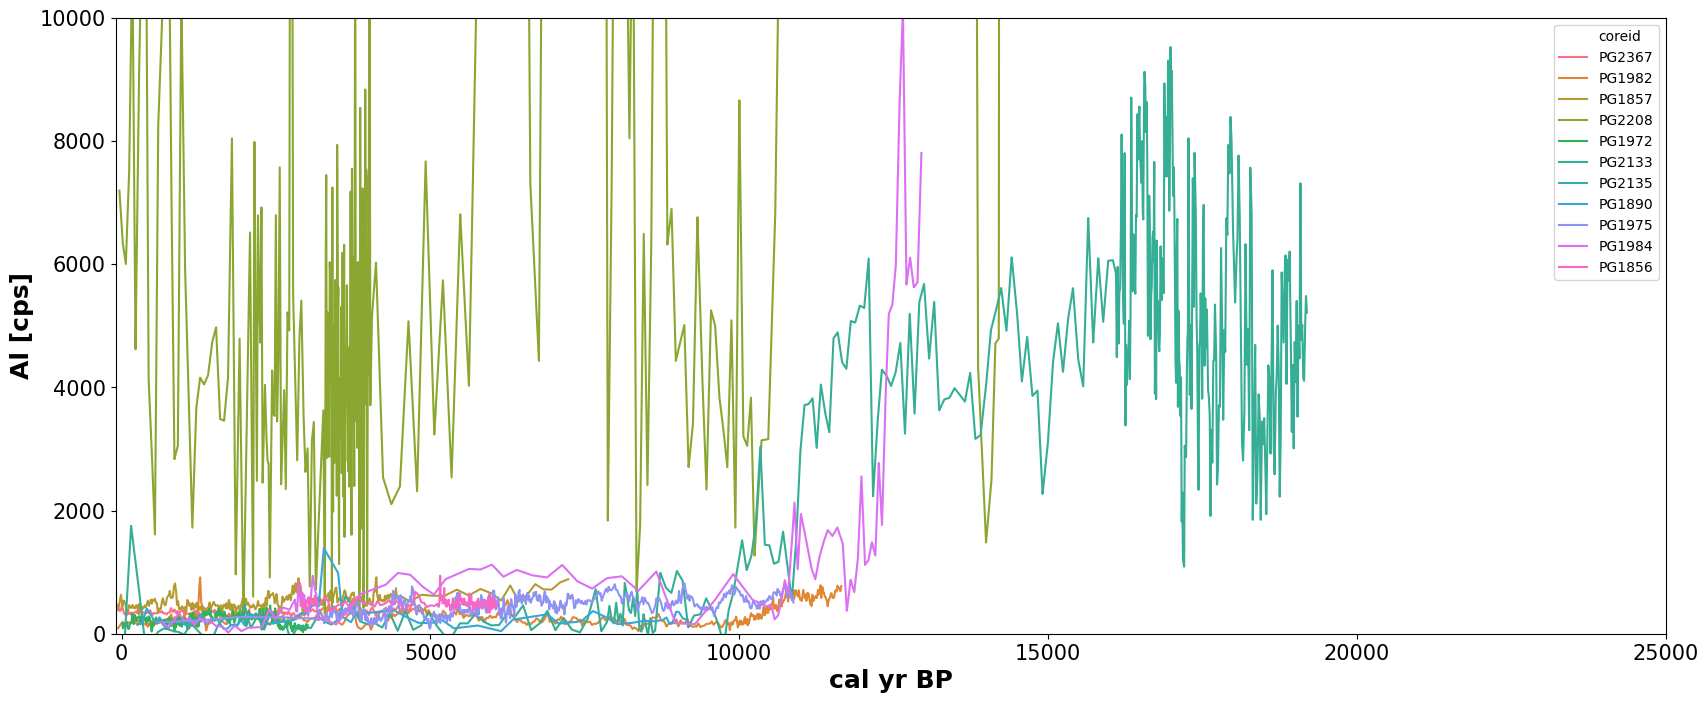

In [51]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Al_Area', hue = 'coreid', data = Al_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylim(0, 10000)
plt.ylabel('Al [cps]', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/cps_Al_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Silicium

In [33]:
df_Si_Area = df_element_total['Si_Area'].to_frame()
df_Si_Area = df_Si_Area.dropna()
df_Si_Area = df_Si_Area.reset_index()
df_Si_Area = df_Si_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Si_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [34]:
df_Si_Area = df_Si_Area.reindex(range(int(df_Si_Area.index[0]),int(df_Si_Area.index[-1])+1, 1))
df_Si_Area_interpolate = df_Si_Area.interpolate('from_derivatives')
Si_Area_Comparable = df_Si_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Si_Area'})
Si_Area_Comparable = Si_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

#### Plotting data

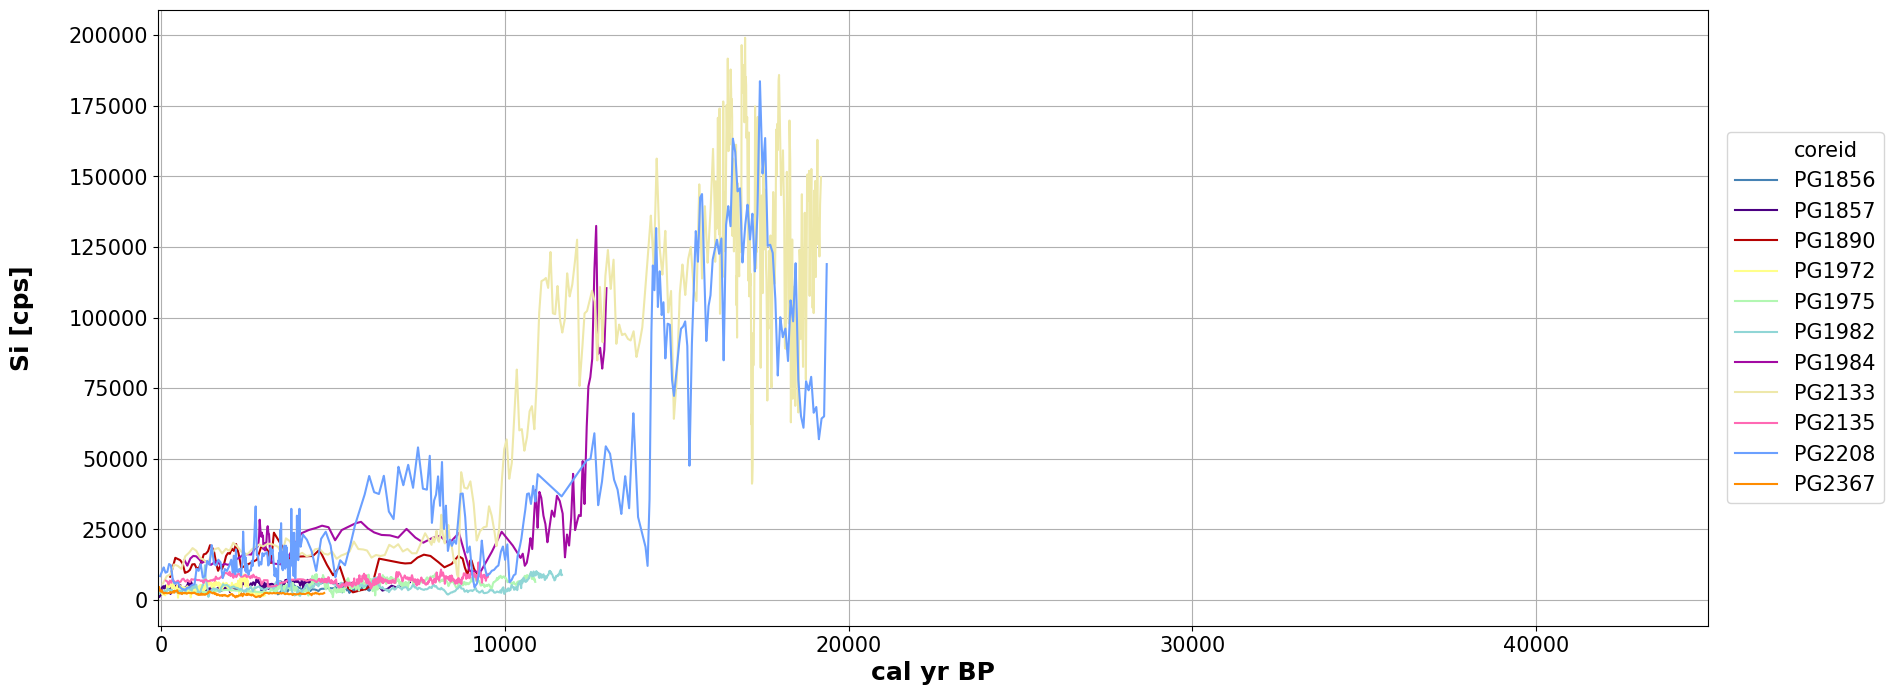

In [35]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Si_Area', 
                  hue = 'coreid', data = Si_Area_Comparable, 
                  palette = Si_palette_colors, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Si [cps]', weight = 'bold', labelpad = 25)
plt.xlabel('cal yr BP', weight = 'bold')
plt.legend(ncol = 1, fontsize = MEDIUM_SIZE, loc = 'right', bbox_to_anchor = (1.12, 0.5))
plt.grid(True)
plt.savefig('Figures/cps_Si_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Al/Si

In [55]:
Al_Si = pd.merge(Al_Area_Comparable, Si_Area_Comparable, how = 'inner', on = ['coreid', 'modeloutput_median'])
Al_Si['Ratio'] = Al_Si['Al_Area']/Al_Si['Si_Area']

#### Plotting data

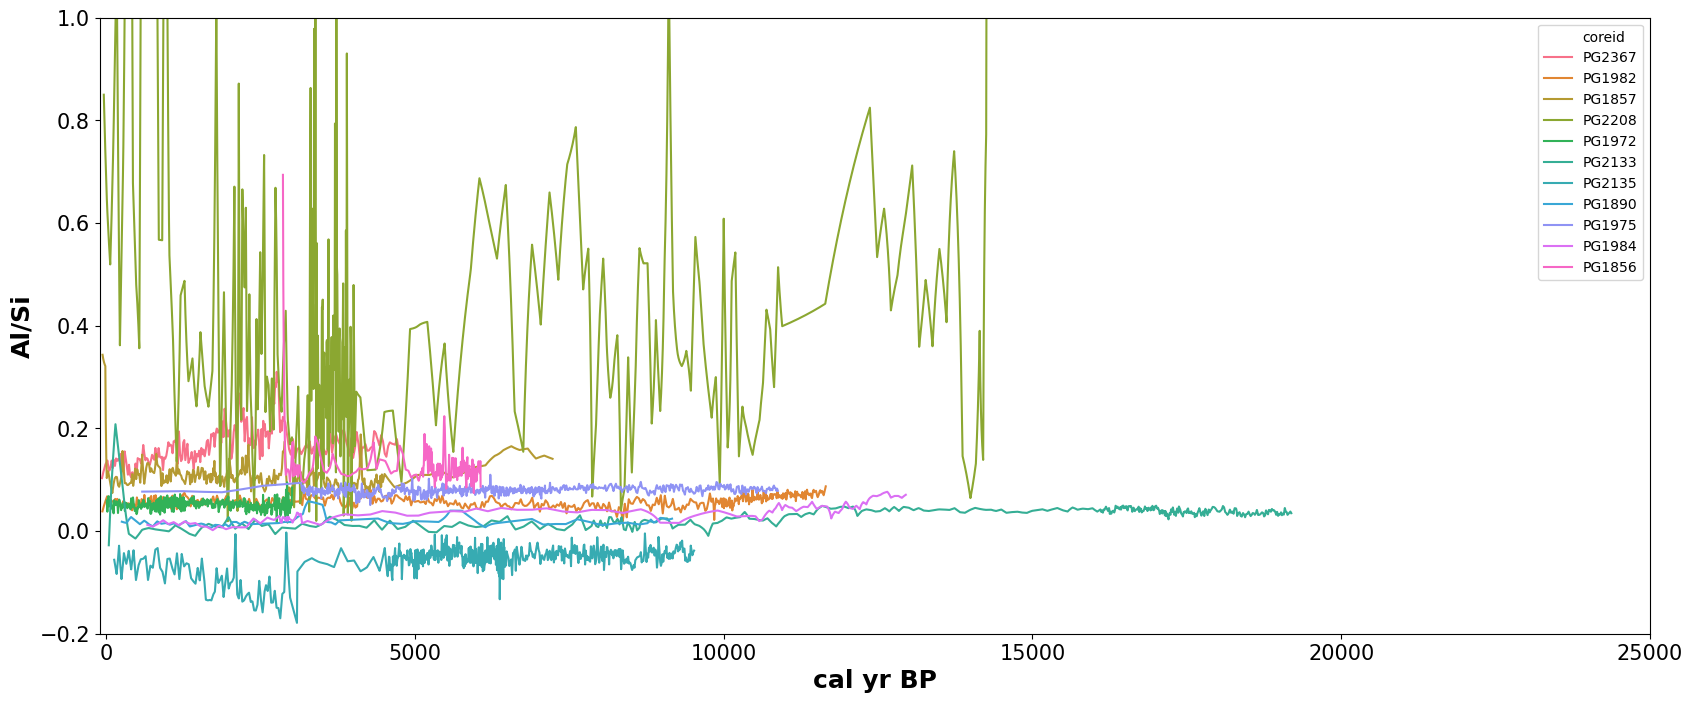

In [56]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ratio', hue = 'coreid', data = Al_Si, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylim(-0.2, 1)
plt.ylabel('Al/Si', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/cps_AL_Si_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Bromine

In [36]:
df_Br_Area = df_element_total['Br_Area'].to_frame()
df_Br_Area = df_Br_Area.dropna()
df_Br_Area = df_Br_Area.reset_index()
df_Br_Area = df_Br_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Br_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [37]:
df_Br_Area = df_Br_Area.reindex(range(int(df_Br_Area.index[0]),int(df_Br_Area.index[-1])+1, 1))
df_Br_Area_interpolate = df_Br_Area.interpolate('from_derivatives')
Br_Area_Comparable = df_Br_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Br_Area'})
Br_Area_Comparable = Br_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

#### Plotting data

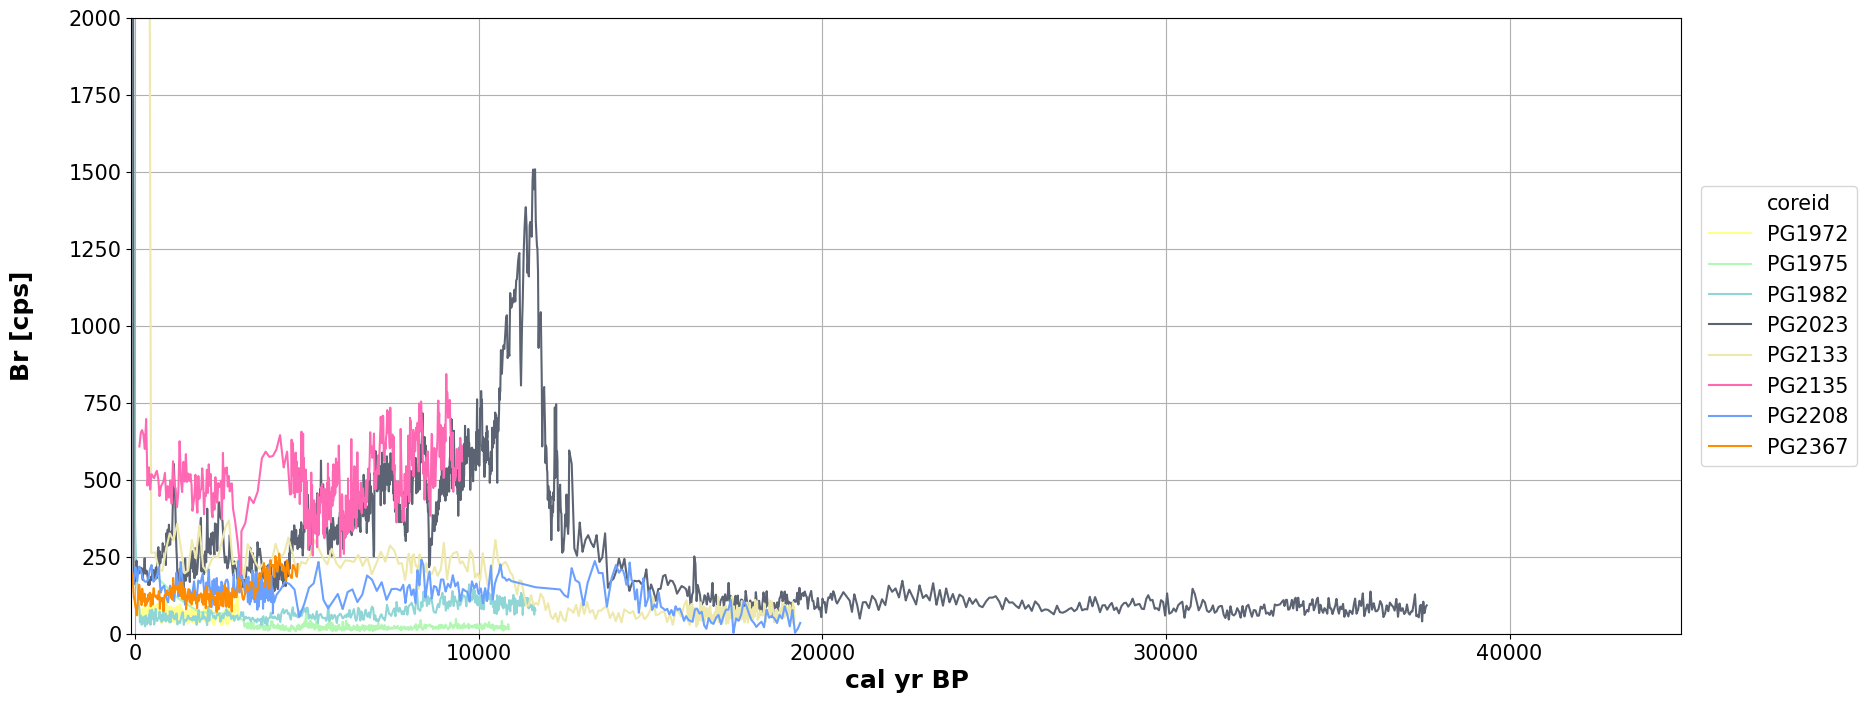

In [38]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Br_Area', 
                  hue = 'coreid', data = Br_Area_Comparable, 
                  palette = Br_palette_colors, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylim(0, 2000)
plt.ylabel('Br [cps]', weight = 'bold', labelpad = 25)
plt.xlabel('cal yr BP', weight = 'bold')
plt.legend(ncol = 1, fontsize = MEDIUM_SIZE, loc = 'right', bbox_to_anchor = (1.12, 0.5))
plt.grid(True)
plt.savefig('Figures/cps_Br_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Titanium

In [39]:
df_Ti_Area = df_element_total['Ti_Area'].to_frame()
df_Ti_Area = df_Ti_Area.dropna()
df_Ti_Area = df_Ti_Area.reset_index()
df_Ti_Area = df_Ti_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Ti_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [40]:
df_Ti_Area = df_Ti_Area.reindex(range(int(df_Ti_Area.index[0]),int(df_Ti_Area.index[-1])+1, 1))
df_Ti_Area_interpolate = df_Ti_Area.interpolate('from_derivatives')
Ti_Area_Comparable = df_Ti_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Ti_Area'})
Ti_Area_Comparable = Ti_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

#### Plotting data

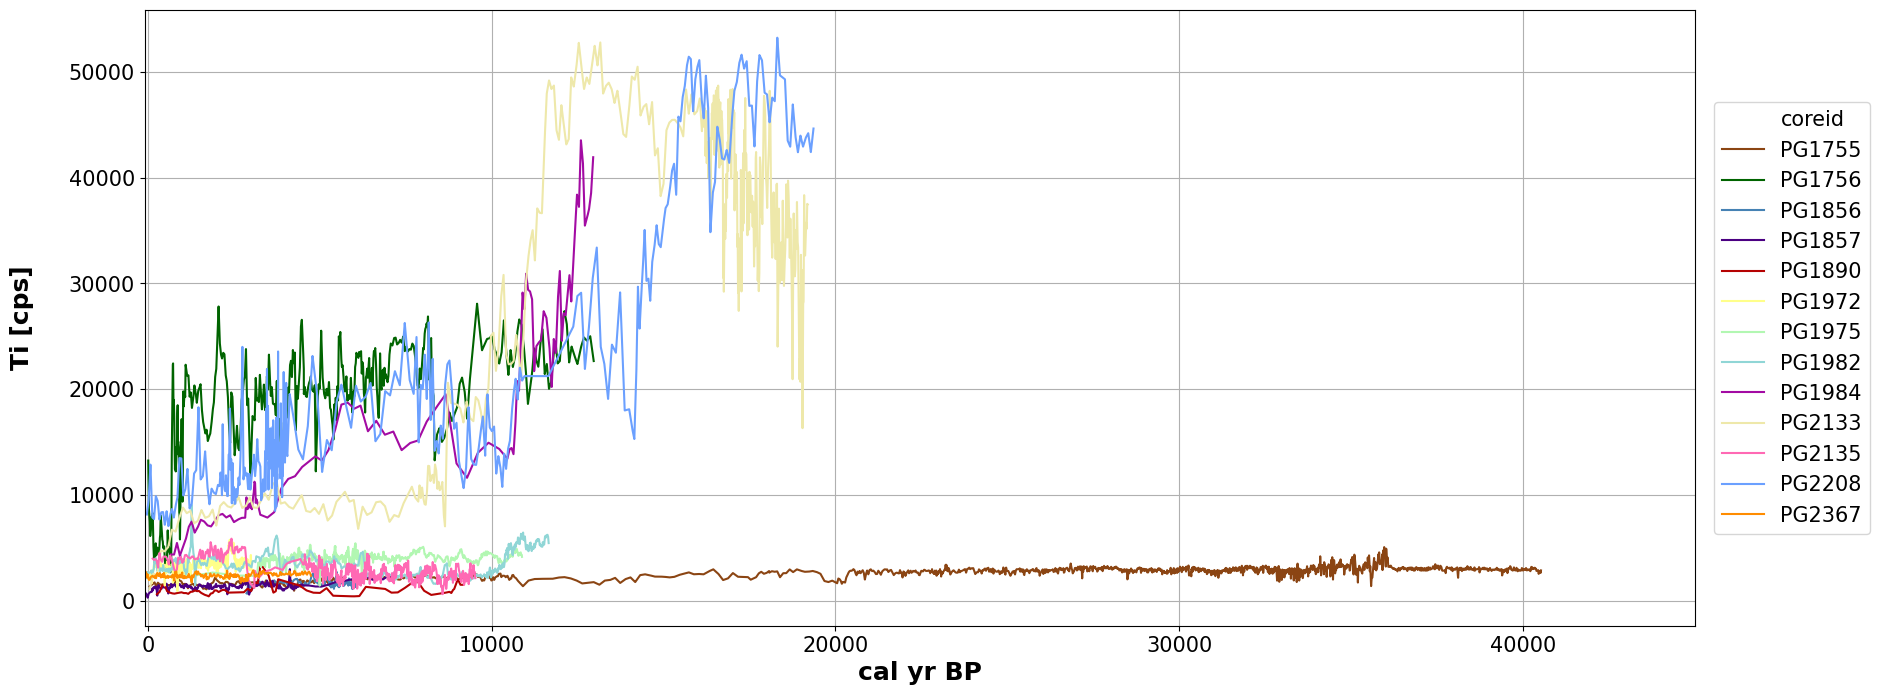

In [41]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ti_Area', 
                  hue = 'coreid', data = Ti_Area_Comparable, 
                  palette = Ti_palette_colors, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Ti [cps]', weight = 'bold', labelpad = 25)
plt.xlabel('cal yr BP', weight = 'bold')
plt.legend(ncol = 1, fontsize = MEDIUM_SIZE, loc = 'right', bbox_to_anchor = (1.12, 0.5))
plt.grid(True)
plt.savefig('Figures/cps_Ti_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Zircon

In [63]:
df_Zr_Area = df_element_total['Zr_Area'].to_frame()
df_Zr_Area = df_Zr_Area.dropna()
df_Zr_Area = df_Zr_Area.reset_index()
df_Zr_Area = df_Zr_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Zr_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [64]:
df_Zr_Area = df_Zr_Area.reindex(range(int(df_Zr_Area.index[0]),int(df_Zr_Area.index[-1])+1, 1))
df_Zr_Area_interpolate = df_Zr_Area.interpolate('from_derivatives')
Zr_Area_Comparable = df_Zr_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Zr_Area'})

#### Plotting data

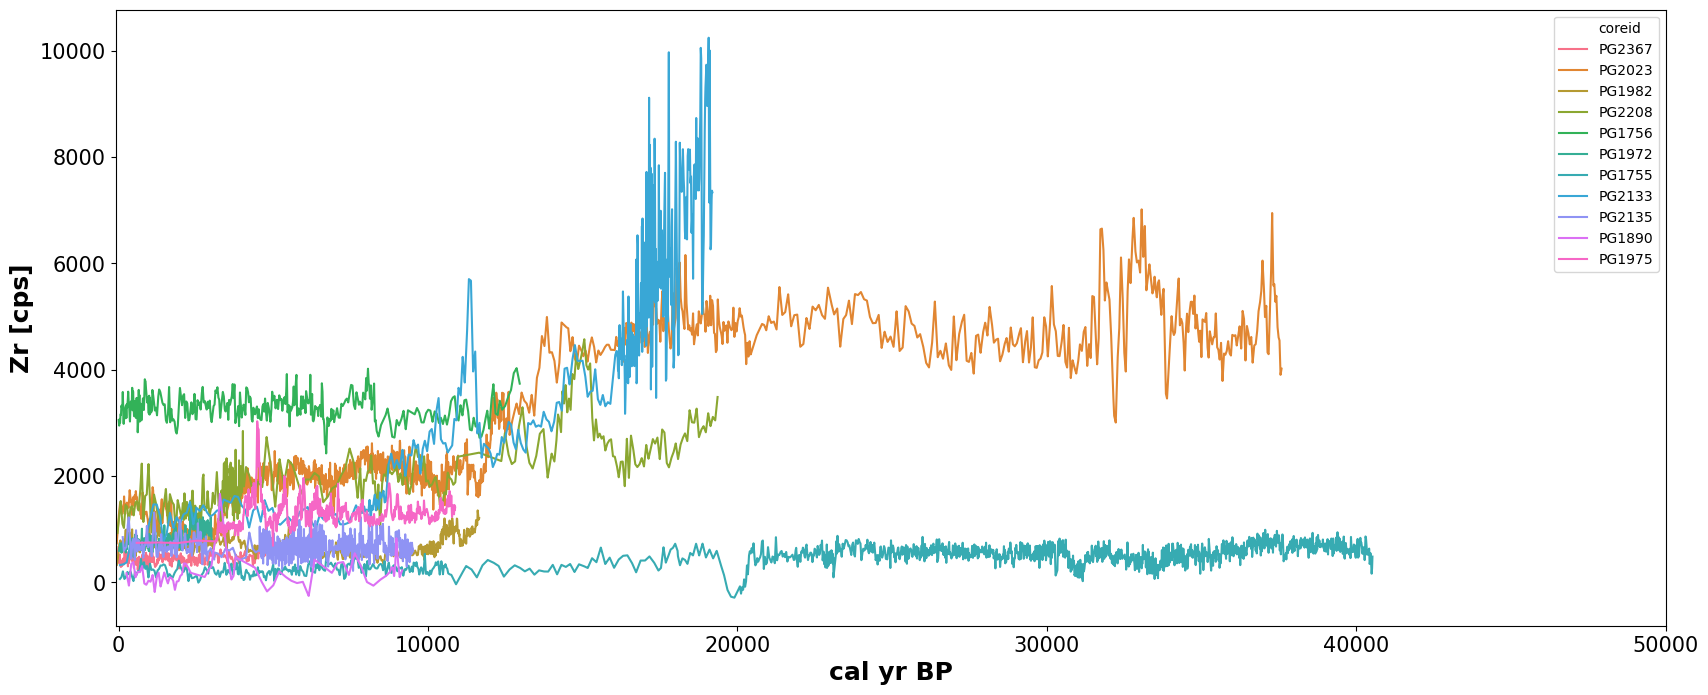

In [65]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Zr_Area', hue = 'coreid', data = Zr_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 50000)
plt.ylabel('Zr [cps]', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/cps_Zr_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Calcium

In [42]:
df_Ca_Area = df_element_total['Ca_Area'].to_frame()
df_Ca_Area = df_Ca_Area.dropna()
df_Ca_Area = df_Ca_Area.reset_index()
df_Ca_Area = df_Ca_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Ca_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [43]:
df_Ca_Area = df_Ca_Area.reindex(range(int(df_Ca_Area.index[0]),int(df_Ca_Area.index[-1])+1, 1))
df_Ca_Area_interpolate = df_Ca_Area.interpolate('from_derivatives')
Ca_Area_Comparable = df_Ca_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Ca_Area'})
Ca_Area_Comparable = Ca_Area_Comparable.sort_values(by = ['coreid','modeloutput_median'])

#### Plotting data

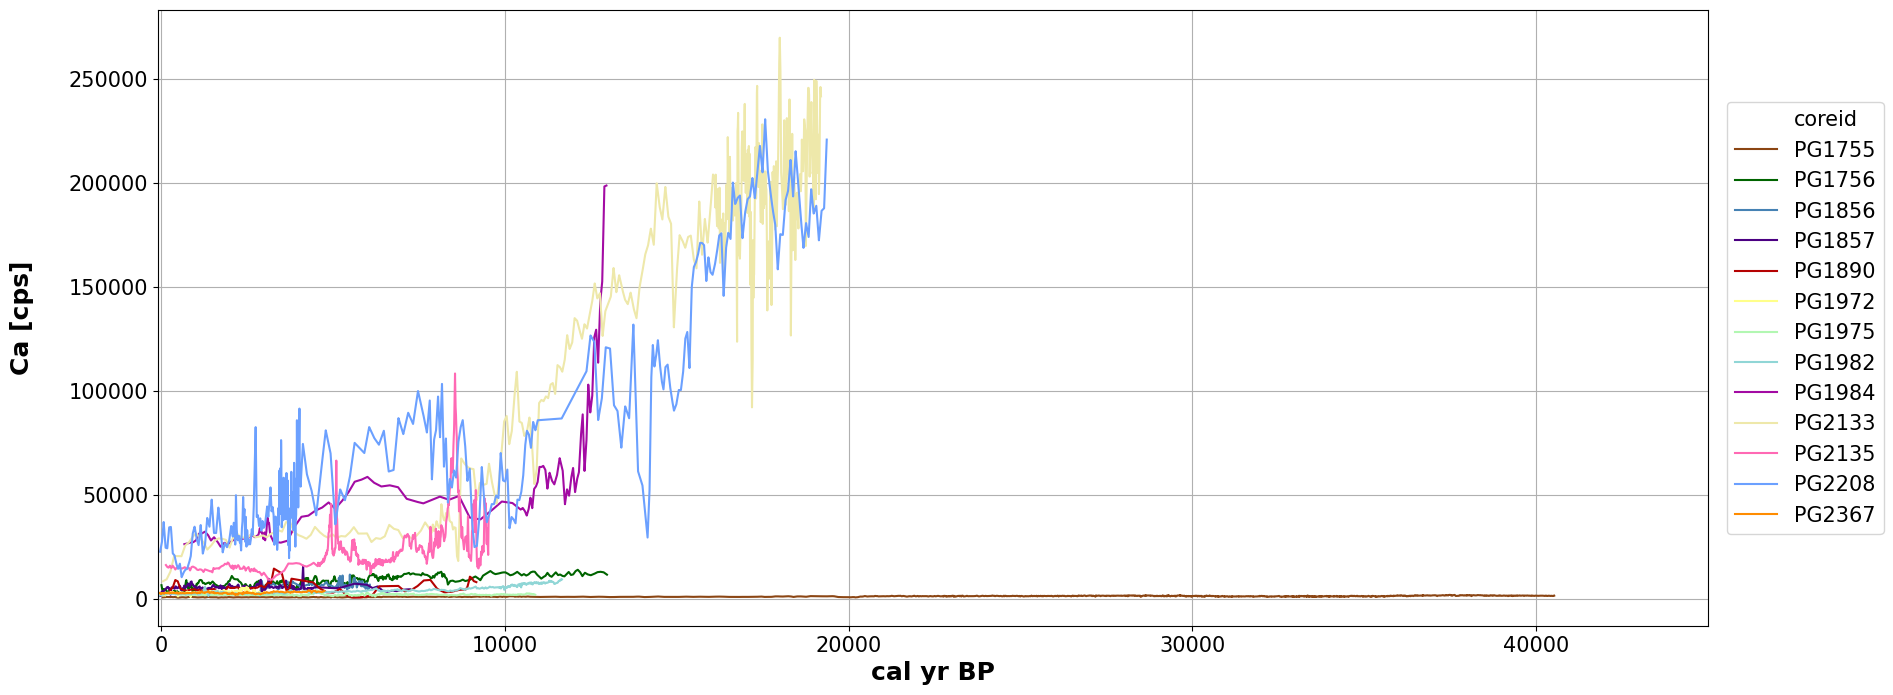

In [44]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ca_Area', 
                  hue = 'coreid', data = Ca_Area_Comparable, 
                  palette = Ca_palette_colors, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 45000)
plt.ylabel('Ca [cps]', weight = 'bold', labelpad = 25)
plt.xlabel('cal yr BP', weight = 'bold')
plt.legend(ncol = 1, fontsize = MEDIUM_SIZE, loc = 'right', bbox_to_anchor = (1.12, 0.5))
plt.grid(True)
plt.savefig('Figures/cps_Ca_element.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()

## Manganese

In [69]:
df_Mn_Area = df_element_total['Mn_Area'].to_frame()
df_Mn_Area = df_Mn_Area.dropna()
df_Mn_Area = df_Mn_Area.reset_index()
df_Mn_Area = df_Mn_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Mn_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [70]:
df_Mn_Area = df_Mn_Area.reindex(range(int(df_Mn_Area.index[0]),int(df_Mn_Area.index[-1])+1, 1))
df_Mn_Area_interpolate = df_Mn_Area.interpolate('from_derivatives')
Mn_Area_Comparable = df_Mn_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Mn_Area'})

#### Plotting data

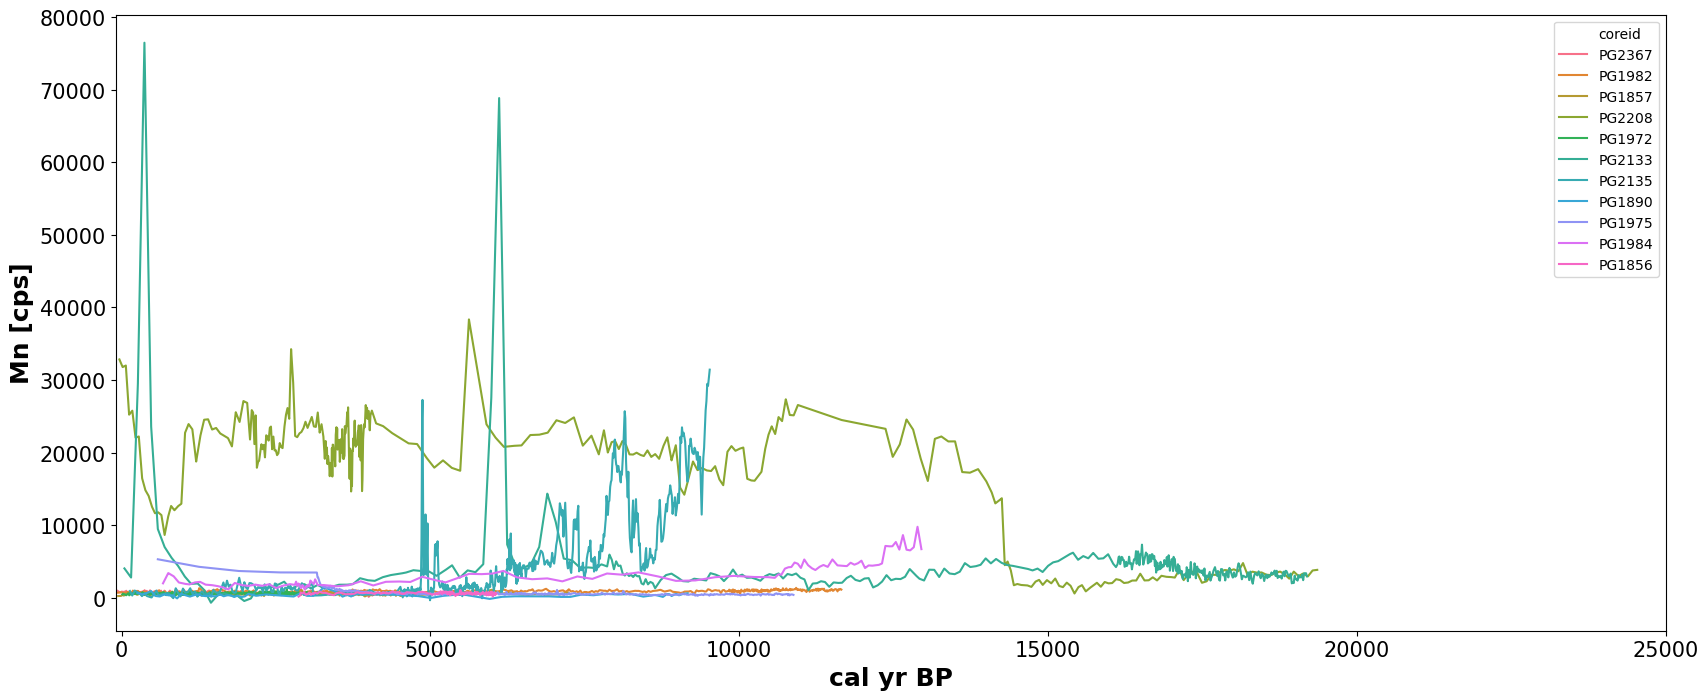

In [71]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Mn_Area', hue = 'coreid', data = Mn_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
plt.ylabel('Mn [cps]', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/cps_Mn_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Iron

In [72]:
df_Fe_Area = df_element_total['Fe_Area'].to_frame()
df_Fe_Area = df_Fe_Area.dropna()
df_Fe_Area = df_Fe_Area.reset_index()
df_Fe_Area = df_Fe_Area.pivot_table(index = 'modeloutput_median', columns = 'coreid', values = 'Fe_Area')

#### Preparation of data (evenly spacing out ages to one year resolution, interpolate elemental values, stacking data for plotting)

In [73]:
df_Fe_Area = df_Fe_Area.reindex(range(int(df_Fe_Area.index[0]),int(df_Fe_Area.index[-1])+1, 1))
df_Fe_Area_interpolate = df_Fe_Area.interpolate('from_derivatives')
Fe_Area_Comparable = df_Fe_Area_interpolate.stack().to_frame().reset_index().rename(columns = {0 : 'Fe_Area'})

#### Plotting data

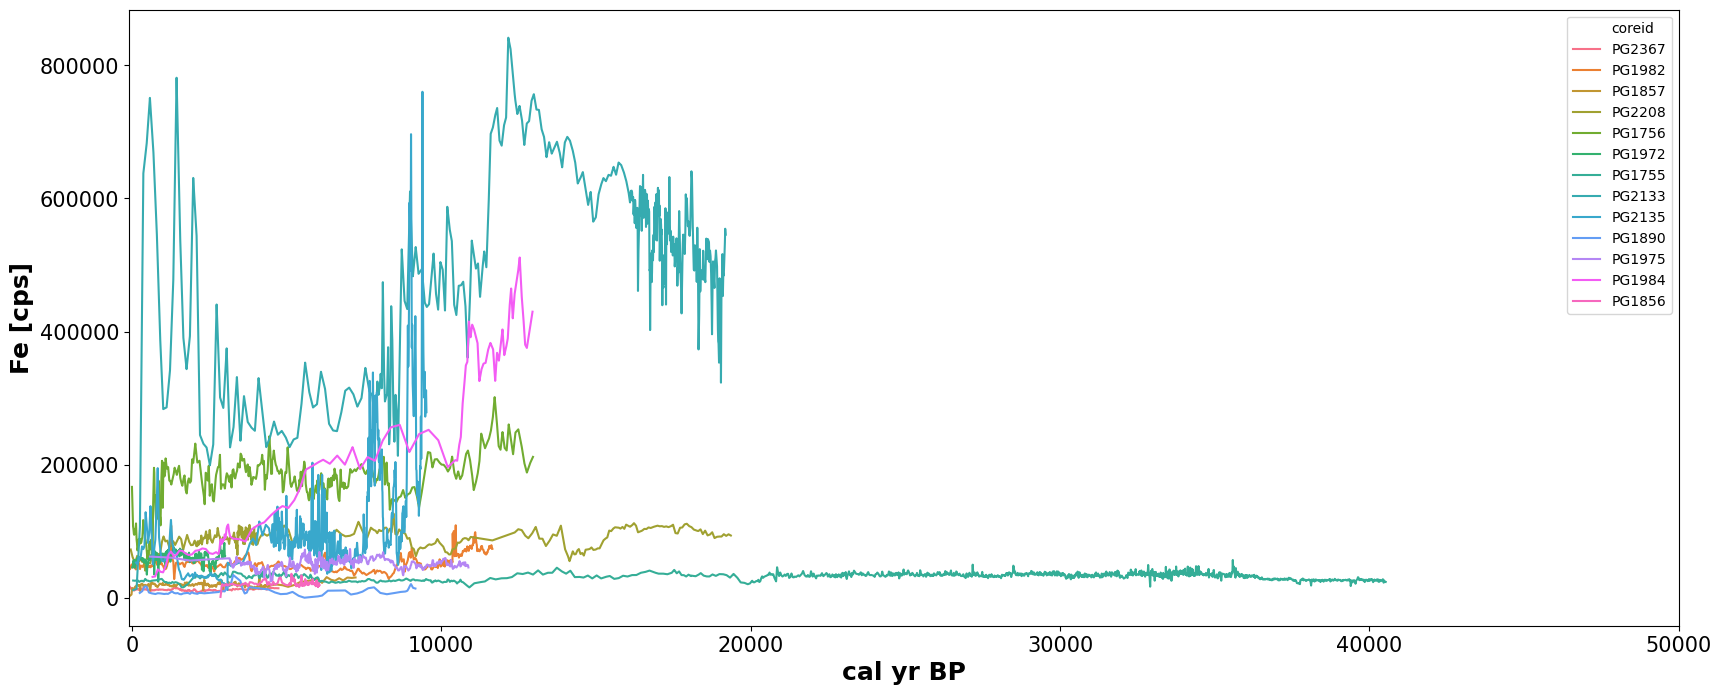

In [74]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Fe_Area', hue = 'coreid', data = Fe_Area_Comparable, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 50000)
plt.ylabel('Fe [cps]', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/cps_Fe_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Mn/Fe Ratio

In [75]:
Mn_Fe = pd.merge(Mn_Area_Comparable, Fe_Area_Comparable, how = 'inner', on = ['coreid', 'modeloutput_median'])
Mn_Fe['Ratio'] = Mn_Fe['Mn_Area']/Mn_Fe['Fe_Area']

#### Plotting data

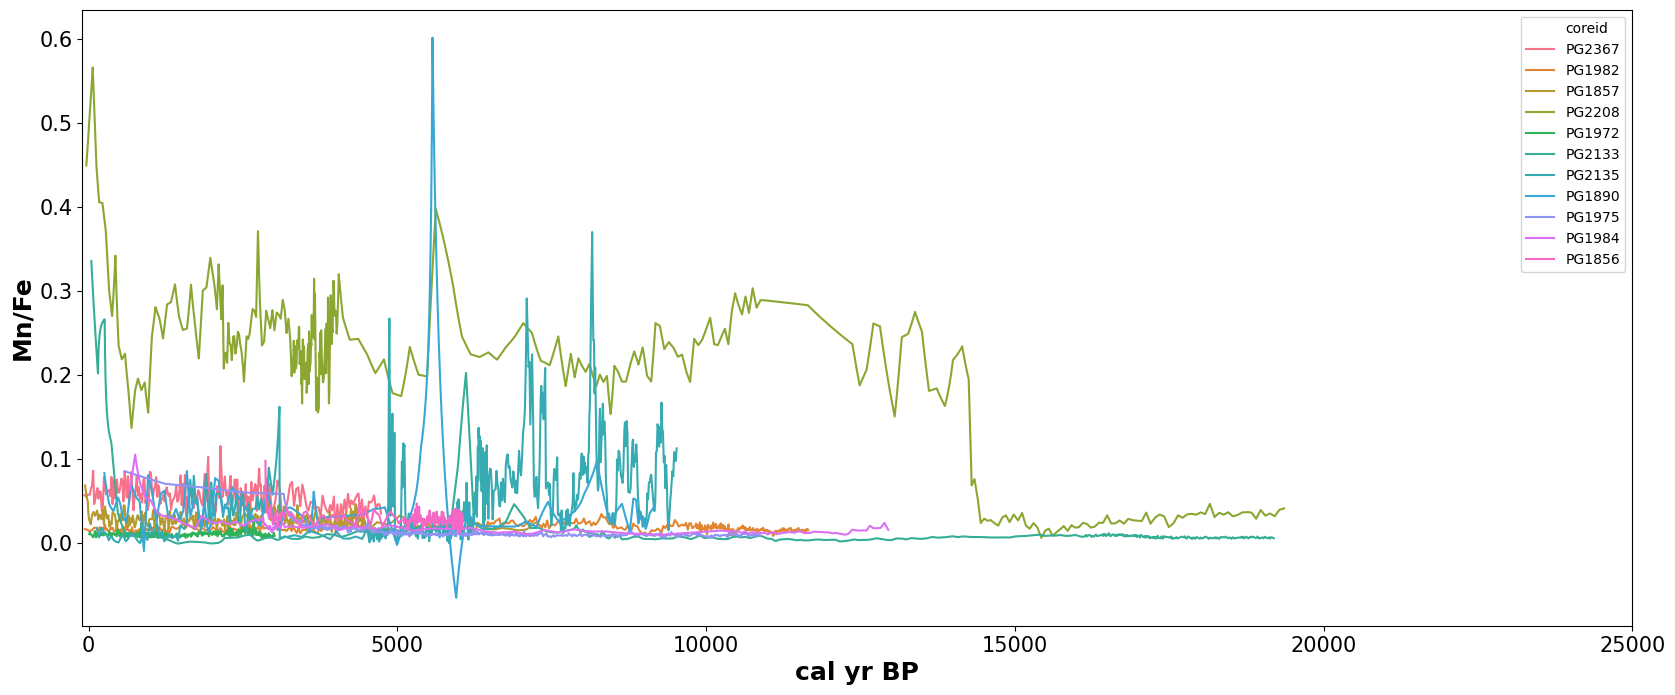

In [76]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'Ratio', hue = 'coreid', data = Mn_Fe, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 25000)
#plt.ylim(-0.2, 1)
plt.ylabel('Mn/Fe', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.savefig('Figures/cps_Mn_Fe_element.png', dpi = 300, bbox_inches = 'tight')
plt.show()